In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import os
import gym
from gym import spaces
import numpy as np


In [2]:
class CrowdNavigationEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(CrowdNavigationEnv, self).__init__()
        self.action_space = spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.state = None
        self.goal = np.array([0.5, 0.5])
        self.reset()
        
    def reset(self):
        self.state = np.random.rand(4)
        return self.state
    
    def step(self, action):
        self.state[0] += action[0] * 0.1
        self.state[1] += action[1] * 0.1
        distance_to_goal = np.linalg.norm(self.state[:2] - self.goal)
        reward = -distance_to_goal
        done = distance_to_goal < 0.1
        return self.state, reward, done, {}
    
    def render(self, mode='human', close=False):
        plt.figure(figsize=(5, 5))
        ax = plt.gca()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # Draw goal
        goal_circle = plt.Circle(self.goal, 0.03, color='green')
        ax.add_patch(goal_circle)

        # Draw robot
        robot_circle = plt.Circle(self.state[:2], 0.03, color='blue')
        ax.add_patch(robot_circle)

        # Draw obstacles (assuming self.state[2:] represents obstacles)
        obstacle_circle = plt.Circle(self.state[2:], 0.03, color='red')
        ax.add_patch(obstacle_circle)

        plt.title("Crowd Navigation Simulation")
        plt.show()
        
    def close(self):
        pass

from gym.envs.registration import register

register(
    id='CrowdNavigation-v0',
    entry_point='__main__:CrowdNavigationEnv',
)

In [3]:
env = gym.make('CrowdNavigation-v0')

In [4]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 400)
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, action_dim)
        self.max_action = max_action
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.tanh(self.layer3(x)) * self.max_action
        return x

In [5]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 400)
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, 1)
    
    def forward(self, x, u):
        x = torch.cat([x, u], 1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [6]:
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        index = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in index]

    def size(self):
        return len(self.buffer)

In [7]:
def ddpg_update(actor, critic, target_actor, target_critic, buffer, batch_size, gamma, tau, actor_optimizer, critic_optimizer):
    batch = buffer.sample(batch_size)
    state, action, reward, next_state, done = zip(*batch)
    
    state = torch.FloatTensor(state)
    action = torch.FloatTensor(action)
    reward = torch.FloatTensor(reward).unsqueeze(1)
    next_state = torch.FloatTensor(next_state)
    done = torch.FloatTensor(done).unsqueeze(1)
    
    target_action = target_actor(next_state)
    target_q = target_critic(next_state, target_action)
    target_value = reward + (1 - done) * gamma * target_q
    critic_loss = nn.MSELoss()(critic(state, action), target_value.detach())
    
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    
    actor_loss = -critic(state, actor(state)).mean()
    
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    
    for target_param, param in zip(target_critic.parameters(), critic.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    for target_param, param in zip(target_actor.parameters(), actor.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


In [8]:
env = gym.make('CrowdNavigation-v0')

actor = Actor(state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0], max_action=env.action_space.high[0])
critic = Critic(state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0])
target_actor = Actor(state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0], max_action=env.action_space.high[0])
target_critic = Critic(state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0])

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

replay_buffer = ReplayBuffer()

num_episodes = 2
batch_size = 64
gamma = 0.99
tau = 0.005
rewards = []


In [9]:
if not os.path.exists('plots'):
    os.makedirs('plots')

Episode 0, Reward: -14.3987363821346


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/Library/Frameworks/Python.

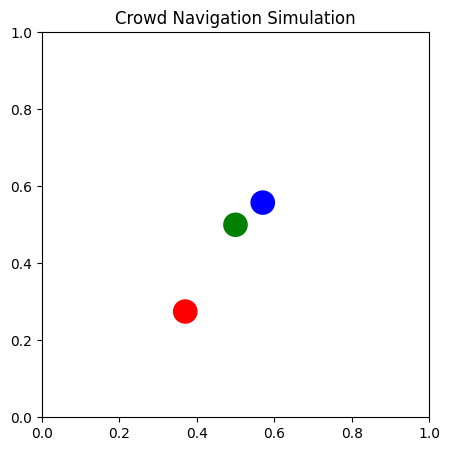

/var/folders/xz/1jd529mj0dx1g2_x97jly0zm0000gn/T/ipykernel_8418/2911775865.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  state = torch.FloatTensor(state)
/var/folders/xz/1jd529mj0dx1g2_x97jly0zm0000gn/T/ipykernel_8418/2911775865.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  done = torch.FloatTensor(done).unsqueeze(1)


In [ ]:
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    
    while True:
        action = actor(torch.FloatTensor(state).unsqueeze(0)).detach().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, done))
        
        state = next_state
        episode_reward += reward
        
        if replay_buffer.size() > batch_size:
            ddpg_update(actor, critic, target_actor, target_critic, replay_buffer, batch_size, gamma, tau, actor_optimizer, critic_optimizer)
        
        if done:
            break
    
    rewards.append(episode_reward)
    print(f"Episode {episode}, Reward: {episode_reward}")

    env.render()
    
    # plt.figure()
    # plt.plot(rewards)
    # plt.xlabel('Episode')
    # plt.ylabel('Reward')
    # plt.title('Training Reward Over Episodes')
    # plt.savefig(f'plots/rewards_{episode}.png')
    # plt.close()